In [16]:
!pip install torchvision
!pip install pyro-ppl
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


# Bayesian Neural Network

Basic idea is to calculate the posterior using:

$\mathrm{P(H|D)}=\frac{P(D|H)P(H)}{P(D)}$ = $\frac{P(D, H)}{\int_H P(D, H^{'})\mathrm{d}H^{'}}$

where D is the dataset and H is the model parameter.

P(D|H) is easy to calculate since we know the prior P(H). And the prior P(H) is a known quantity beforehand, so the only quantity that requires a lot of work to find is the denominator. 

But the integral or evidence is very hard to calculate since we need to calculate the joint probability $P(D, H^{'})$ over all model parameters H which is continuous and infinite. 

Therefore, we need a way of calculating either this integral or the whole posterior in a fast and efficient manner.

To cauclate the evidence, we need an efficient sampling method that is able to approximate the posterior. Two methods that are most commonly used is Markov Chain Monte Carlo method or variational inference.

MCMC is a method where you construct a Markov chain which is just a sequence of random samples S

In [66]:
import os

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from typing import List
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule, PyroSample
from torch import randn
from torch.nn import Identity, LogSoftmax, ReLU, Sequential, Softmax
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import Tensor
from torchvision.datasets import MNIST, CIFAR10
from tqdm import trange


# CONSTANTS

In [54]:
BATCH_SIZE = 128
EPOCH = 40

# MODEL

In [56]:
class BayesianMLP(PyroModule):
  def __init__(self, input_size:int = 784, output_size:int = 10):
    """
    creates a Bayesian MLP with input nodes of size input_size and output nodes of size output_size

    :param input_size: dimension of input
    :param output_size: dimension of output
    :return: BayesianMLP object
    """
    super().__init__()
    self.fc1 = PyroModule[nn.Linear](1024, input_size)
    self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([1024, input_size]).to_event(2))
    self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([1024]).to_event(1))
    self.fc2 = PyroModule[nn.Linear](output_size, 1024)
    self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_size, 1024]).to_event(2))
    self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_size]).to_event(1))
    self.relu = nn.ReLU()
    self.softmax = LogSoftmax(dim=1)
  
  def forward(self, input, output=None):
    """
    forwards input through the BayesianMLP

    :param input: input to the network
    :param output: observed variable
    :return: sampled output
    """
    out = self.fc1(input)
    out = self.relu(out)
    out = self.fc2(out)

    logits = self.softmax(out)

    with pyro.plate("data", out.shape[0]):
        return pyro.sample("obs", dist.Categorical(logits=logits), obs=output)

# DATASET PREPARATION

In [57]:
train_dataset = MNIST(
    root = os.getcwd(), 
    train = True, 
    download = True, 
    transform = transforms.Compose(
        [
          transforms.ToTensor(), 
          transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

test_dataset = MNIST(
    root = os.getcwd(), 
    train = False, 
    download = True, 
    transform = transforms.Compose(
        [
          transforms.ToTensor(), 
          transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
)

# TRAINING

Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.11it/s]


At epoch: 0 the loss was: 4751343.183026357


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.58it/s]


At epoch: 1 the loss was: 3532529.1672282377


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.22it/s]


At epoch: 2 the loss was: 2436744.8956352137


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.31it/s]


At epoch: 3 the loss was: 1529338.0400264165


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.10it/s]


At epoch: 4 the loss was: 864496.2155754431


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.16it/s]


At epoch: 5 the loss was: 450503.85421465104


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.11it/s]


At epoch: 6 the loss was: 233216.22652964946


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.44it/s]


At epoch: 7 the loss was: 132180.031463176


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.44it/s]


At epoch: 8 the loss was: 87190.24977963045


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.49it/s]


At epoch: 9 the loss was: 66769.6324028857


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.20it/s]


At epoch: 10 the loss was: 56539.6187197268


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.44it/s]


At epoch: 11 the loss was: 50965.34050164744


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.47it/s]


At epoch: 12 the loss was: 48277.17024314776


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.17it/s]


At epoch: 13 the loss was: 46267.32499425858


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.60it/s]


At epoch: 14 the loss was: 44935.11916195601


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.24it/s]


At epoch: 15 the loss was: 44133.78112894297


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.46it/s]


At epoch: 16 the loss was: 43363.161490656435


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.32it/s]


At epoch: 17 the loss was: 43221.800300017


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.41it/s]


At epoch: 18 the loss was: 42429.89156751335


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.99it/s]


At epoch: 19 the loss was: 42111.906178846955


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.92it/s]


At epoch: 20 the loss was: 41705.82100690156


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.35it/s]


At epoch: 21 the loss was: 41858.49648690969


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.53it/s]


At epoch: 22 the loss was: 41360.32131327689


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.91it/s]


At epoch: 23 the loss was: 41452.62125771493


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.10it/s]


At epoch: 24 the loss was: 40917.27993545681


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.71it/s]


At epoch: 25 the loss was: 40719.01121405512


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.01it/s]


At epoch: 26 the loss was: 40424.58570318669


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.62it/s]


At epoch: 27 the loss was: 40340.59591843933


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.88it/s]


At epoch: 28 the loss was: 40008.41429132223


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.91it/s]


At epoch: 29 the loss was: 39904.91870614886


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.56it/s]


At epoch: 30 the loss was: 39920.07426185906


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.41it/s]


At epoch: 31 the loss was: 39903.83296249807


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.08it/s]


At epoch: 32 the loss was: 39531.34138819575


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.56it/s]


At epoch: 33 the loss was: 39483.143574886024


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 22.39it/s]


At epoch: 34 the loss was: 39242.07673315704


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.17it/s]


At epoch: 35 the loss was: 39319.739766426384


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.43it/s]


At epoch: 36 the loss was: 39168.960543856025


Processed image 467: 100%|██████████| 468/468 [00:19<00:00, 23.41it/s]


At epoch: 37 the loss was: 39072.871697604656


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.08it/s]


At epoch: 38 the loss was: 39091.417410194874


Processed image 467: 100%|██████████| 468/468 [00:20<00:00, 23.05it/s]

At epoch: 39 the loss was: 38925.95010703057


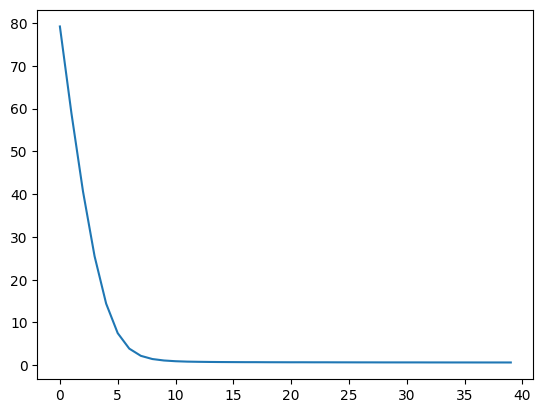

In [58]:
model = BayesianMLP()
guide = AutoNormal(model) # use Normal distribution as prior guide for SVI. This is the approximation of the posterior P(H|D)
adam = pyro.optim.Adam({"lr": 0.001}) # Adam optimizer for SVI
svi = SVI(model, guide, adam, loss=Trace_ELBO()) # specify ELBO loss using Stochastic Variational Inference

pyro.clear_param_store() # clear out any stored parameter from pyro 

epoch_losses = []

for e in range(EPOCH):
  loss = 0
  tbar = trange(len(train_loader.dataset)//BATCH_SIZE)
  for data, i in zip(train_loader, tbar):
    x = torch.flatten(data[0], start_dim = 1)
    y = data[1]
    tbar.set_description(f"Processed image {i}")
    loss += svi.step(x, y) / BATCH_SIZE
   
  epoch_loss = loss / len(train_loader.dataset)
  epoch_losses.append(epoch_loss)
  print(f"At epoch: {e} the loss was: {loss}")

plt.plot([loss/10000 for loss in epoch_losses])
plt.xlabel("Epoch")
plt.ylabel("Epoch Loss")

# PREDICTION ON MNIST

In [64]:
def display_inference(display:int, images: List[Tensor], means: List[int], stds: List[float]):
    f, axes = plt.subplots(display, 2)
    for i in range(display):
        axes[i, 0].set_axis_off()
        axes[i, 1].set_axis_off()

        axes[i, 0].imshow(images[i], cmap = 'gray')
        axes[i, 1].text(0, 0, f"prediction = {means[i]}, std = {stds[i]}")

In [67]:
def calculate_inference(num_to_sample:int, dataset: Dataset, pred: Predictive):
    dataset = list(dataset)

    sampled = random.sample(dataset, k=num_to_sample)

    images = [sample[0].squeeze(0) for sample in sampled]
    predictions = [pred(sample[0].flatten(0).unsqueeze(0)) for sample in sampled]
    means = [round(prediction['obs'].T.numpy().mean(axis=1)[0]) for prediction in predictions]
    stds = [prediction['obs'].T.numpy().std(axis=1)[0] for prediction in predictions]

    return (images, means, stds)

The bayesian MLP is able to predict the label pretty well with a low standard deviation, meaning that the network is very confident about its answer.

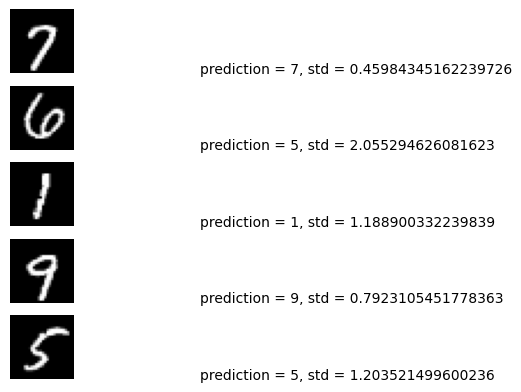

In [70]:
NUM_TO_DISPLAY = 5

pred = Predictive(model, guide=guide, num_samples=500)

display_inference(NUM_TO_DISPLAY, *calculate_inference(NUM_TO_DISPLAY, test_dataset, pred))

# PREDICTION ON CIFAR10

On the other hand, this dataset is very different from MNIST, therefore, the network is very uncertain about its prediction as evidenced by the high standard deviation value for each predicted label.

Files already downloaded and verified


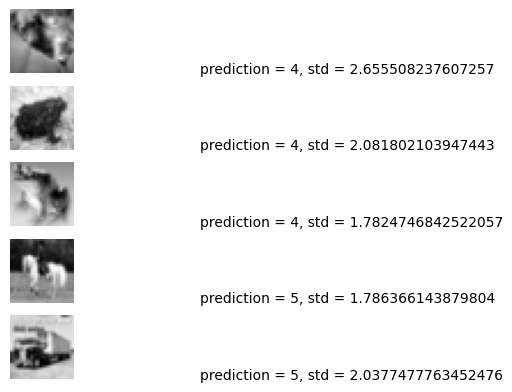

In [83]:
cifar_dataset = CIFAR10(
    root = os.getcwd(), 
    train = False, 
    download = True, 
    transform = transforms.Compose(
        [
          transforms.ToTensor(), 
          transforms.Resize((28, 28)),
          transforms.Grayscale(num_output_channels=1),
          transforms.Normalize((0.5,), (0.5,))
        ]
    )
)

display_inference(NUM_TO_DISPLAY, *calculate_inference(NUM_TO_DISPLAY, cifar_dataset, pred))

In [ ]:
class BayesianCNN(PyroModule):
  def __init__(self, input_size:int = 784, output_size:int = 10):
    """
    creates a Bayesian CNN with input nodes of size input_size and output nodes of size output_size

    :param input_size: dimension of input
    :param output_size: dimension of output
    :return: BayesianCNN object
    """
    super().__init__()
    
  
  def forward(self, input, output=None):
    """
    forwards input through the BayesianCNN

    :param input: input to the network
    :param output: observed variable
    :return: sampled output
    """
    out = self.fc1(input)
    out = self.relu(out)
    out = self.fc2(out)

    logits = self.softmax(out)

    with pyro.plate("data", out.shape[0]):
        return pyro.sample("obs", dist.Categorical(logits=logits), obs=output)